## Assignment 1 : 
- Fashion-MNIST Dataset으로 MLP를 자유롭게 구현해보세요.
- PyTorch, TensorFlow 선택 자유
- Data 파일을 따로 드리지 않습니다. Dataset과 관련된 모듈을 활용하여 직접 해보시길 바랍니다.
- 공개된 코드를 사용하셔도 좋습니다. 이 경우 출처를 밝혀 주시기 바랍니다.

### 1 :  PyTorch

In [1]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
torch.cuda.current_device()

0

In [3]:
torch.cuda.is_available()

True

### 1 - 1 : Data

In [4]:
# transforms : 데이터 로더에서 가져온 것들을 변환 (Pytorch는 텐서기준으로 돌아감)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

In [5]:
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True,transform=transform )
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [6]:
# Checking the dataset
for image, label in trainloader:
    
    print('Image batch dimensions:', image.shape)
    print('Image label dimensions:', label.shape)
    break

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


______________________________________________________

 ###  1 - 2 : Modeling

In [7]:
# Device # 1회
"""
evice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
learning_rate = 0.1
num_epochs = 10

# Architecture
num_features = 784
num_hidden_1 = 128
num_hidden_2 = 256
num_classes = 10"""

'\nevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\n\n# Hyperparameters\nrandom_seed = 1\nlearning_rate = 0.1\nnum_epochs = 10\n\n# Architecture\nnum_features = 784\nnum_hidden_1 = 128\nnum_hidden_2 = 256\nnum_classes = 10'

In [8]:
# Device # 2회
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
learning_rate = 0.05
num_epochs = 20

# Architecture
num_features = 784
num_hidden_1 = 392
num_hidden_2 = 128
num_classes = 10

_______________________________________

In [9]:
class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        # torch.nn.Module 상속
        super(MultilayerPerceptron, self).__init__()
        
        # Architecture
        # num_features = 784
        # num_hidden_1 = 128
        # num_hidden_2 = 256
        # num_classes = 10
        
        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        
        # The following two lines are not necessary, 
        # but used here to demonstrate how to access the weights
        # and use a different weight initialization.
        # By default, PyTorch uses Xavier/Glorot initialization, which
        # should usually be preferred.
        
        #detach 
        # -> 이유 : 텐서는 계산할 때 마다 Gradient를 저장
        #         : 근데 weight 초기화할 때 연산도 저장하므로 그 부분을 잡아줘야됨
        #         : detac를 이용해 이를 달성
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
        
        ### 2nd hidden layer
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_2.weight.detach().normal_(0.0, 0.1)
        self.linear_2.bias.detach().zero_()
        
        ### Output layer
        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()
        # 여기까지는 output이 10개로만 나오는 과정
        
    def forward(self, x):
        out = self.linear_1(x)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)
        logits = self.linear_out(out) # 10개짜리 weight를 logits 으로 설정
        probas = F.log_softmax(logits, dim=1) # 로그 소프트맥스 사용 
        return logits, probas 

### 1 - 3 : Training & Evaluation

In [10]:
# 만든 모델을 전달    
torch.manual_seed(random_seed)
model = MultilayerPerceptron(num_features=num_features,
                             num_classes=num_classes)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [11]:
# 평가용 함수 생성
def compute_accuracy(net, data_loader):
    net.eval() # 평가
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(device)
            targets = targets.to(device)
            logits, probas = net(features)
            _, predicted_labels = torch.max(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100    

In [12]:
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(trainloader):
        
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(probas, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(trainloader), cost))

    with torch.set_grad_enabled(False):
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, trainloader)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/020 | Batch 000/938 | Cost: 5.7238
Epoch: 001/020 | Batch 050/938 | Cost: 0.7195
Epoch: 001/020 | Batch 100/938 | Cost: 0.7185
Epoch: 001/020 | Batch 150/938 | Cost: 0.6616
Epoch: 001/020 | Batch 200/938 | Cost: 0.6694
Epoch: 001/020 | Batch 250/938 | Cost: 0.5746
Epoch: 001/020 | Batch 300/938 | Cost: 0.5576
Epoch: 001/020 | Batch 350/938 | Cost: 0.5404
Epoch: 001/020 | Batch 400/938 | Cost: 0.4358
Epoch: 001/020 | Batch 450/938 | Cost: 0.6530
Epoch: 001/020 | Batch 500/938 | Cost: 0.5639
Epoch: 001/020 | Batch 550/938 | Cost: 0.7213
Epoch: 001/020 | Batch 600/938 | Cost: 0.4188
Epoch: 001/020 | Batch 650/938 | Cost: 0.4574
Epoch: 001/020 | Batch 700/938 | Cost: 0.3208
Epoch: 001/020 | Batch 750/938 | Cost: 0.3109
Epoch: 001/020 | Batch 800/938 | Cost: 0.2543
Epoch: 001/020 | Batch 850/938 | Cost: 0.5386
Epoch: 001/020 | Batch 900/938 | Cost: 0.2129
Epoch: 001/020 training accuracy: 85.59%
Time elapsed: 0.44 min
Epoch: 002/020 | Batch 000/938 | Cost: 0.3591
Epoch: 002/020 |

Epoch: 018/020 | Batch 400/938 | Cost: 0.0865
Epoch: 018/020 | Batch 450/938 | Cost: 0.0771
Epoch: 018/020 | Batch 500/938 | Cost: 0.1079
Epoch: 018/020 | Batch 550/938 | Cost: 0.1499
Epoch: 018/020 | Batch 600/938 | Cost: 0.0542
Epoch: 018/020 | Batch 650/938 | Cost: 0.2162
Epoch: 018/020 | Batch 700/938 | Cost: 0.1602
Epoch: 018/020 | Batch 750/938 | Cost: 0.2136
Epoch: 018/020 | Batch 800/938 | Cost: 0.2707
Epoch: 018/020 | Batch 850/938 | Cost: 0.1536
Epoch: 018/020 | Batch 900/938 | Cost: 0.2091
Epoch: 018/020 training accuracy: 94.65%
Time elapsed: 9.19 min
Epoch: 019/020 | Batch 000/938 | Cost: 0.0852
Epoch: 019/020 | Batch 050/938 | Cost: 0.1218
Epoch: 019/020 | Batch 100/938 | Cost: 0.0736
Epoch: 019/020 | Batch 150/938 | Cost: 0.0808
Epoch: 019/020 | Batch 200/938 | Cost: 0.3758
Epoch: 019/020 | Batch 250/938 | Cost: 0.2614
Epoch: 019/020 | Batch 300/938 | Cost: 0.1794
Epoch: 019/020 | Batch 350/938 | Cost: 0.1066
Epoch: 019/020 | Batch 400/938 | Cost: 0.1797
Epoch: 019/020 |

- version1 : Epoch 10 lr:0.1 : 89.90%
- version2 : Epoch 20 lr:0.05 : 94.92%

## 2: Tensorflow(Keras)

In [13]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from keras import models
from keras import layers
from keras.layers import Flatten
from keras import regularizers

C:\Users\kcg99\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
Using TensorFlow backend.


### 2 -1 : Data

In [14]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [15]:
from keras.utils import to_categorical
display(train_labels.shape)
categorical_labels = to_categorical(train_labels, num_classes=None)
categorical_test_labels = to_categorical(test_labels, num_classes=None)

display(categorical_labels.shape)

(60000,)

(60000, 10)

In [16]:
train_images = train_images/255
test_images = test_images/255
print(train_images[0].max(), train_images[0].min())
print(test_images[0].max(), test_images[0].min())

1.0 0.0
1.0 0.0


In [17]:
train_images=(train_images-0.5)/0.5 # normalization
test_images=(test_images-0.5)/0.5

In [18]:
train_images=train_images.round(4)
test_images=test_images.round(4)

### 2 - 2 : Modeling

In [19]:
from keras import models
from keras import layers
from keras.optimizers import *
from keras.layers import Flatten
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras import initializers

model1 = models.Sequential()
model1.add(layers.Flatten(input_shape=(28, 28))),
model1.add(layers.Dense(128, activation='relu', input_shape=(28,28), kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)))
model1.add(layers.Dense(256, activation='relu', kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)))
model1.add(layers.Dense(10, activation='softmax',kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)))

model1.summary()

W0903 21:42:56.393280 20656 deprecation_wrapper.py:119] From C:\Users\kcg99\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0903 21:42:56.401262 20656 deprecation_wrapper.py:119] From C:\Users\kcg99\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 21:42:56.423202 20656 deprecation_wrapper.py:119] From C:\Users\kcg99\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 136,074
Trainable params: 136,074
Non-trainable params: 0
_________________________________________________________________


### 2 - 3 : Training & Evaluation

In [20]:
# batch_size도 성능에 영향을 미친다.
model1.compile(optimizer=SGD(lr=0.05), loss='categorical_crossentropy', metrics=['acc'])
history = model1.fit(train_images, categorical_labels, epochs=20, batch_size=64,verbose=1)

W0903 21:42:56.563827 20656 deprecation_wrapper.py:119] From C:\Users\kcg99\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0903 21:42:56.578784 20656 deprecation_wrapper.py:119] From C:\Users\kcg99\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0903 21:42:56.766284 20656 deprecation.py:323] From C:\Users\kcg99\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0903 21:42:56.873000 20656 deprecation_wrapper.py:119] From C:\Users\kcg99\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v

Epoch 1/20
60000/60000 [==============================] - ETA: 6:56 - loss: 4.3244 - acc: 0.078 - ETA: 32s - loss: 1.8589 - acc: 0.443 - ETA: 18s - loss: 1.4040 - acc: 0.56 - ETA: 13s - loss: 1.2077 - acc: 0.61 - ETA: 10s - loss: 1.0906 - acc: 0.64 - ETA: 9s - loss: 1.0355 - acc: 0.6572 - ETA: 8s - loss: 0.9823 - acc: 0.669 - ETA: 7s - loss: 0.9328 - acc: 0.683 - ETA: 6s - loss: 0.8939 - acc: 0.693 - ETA: 6s - loss: 0.8594 - acc: 0.704 - ETA: 5s - loss: 0.8346 - acc: 0.710 - ETA: 5s - loss: 0.8116 - acc: 0.716 - ETA: 5s - loss: 0.7924 - acc: 0.721 - ETA: 4s - loss: 0.7797 - acc: 0.724 - ETA: 4s - loss: 0.7675 - acc: 0.729 - ETA: 4s - loss: 0.7497 - acc: 0.734 - ETA: 4s - loss: 0.7373 - acc: 0.739 - ETA: 4s - loss: 0.7283 - acc: 0.741 - ETA: 3s - loss: 0.7184 - acc: 0.744 - ETA: 3s - loss: 0.7083 - acc: 0.746 - ETA: 3s - loss: 0.7011 - acc: 0.749 - ETA: 3s - loss: 0.6916 - acc: 0.752 - ETA: 3s - loss: 0.6855 - acc: 0.754 - ETA: 3s - loss: 0.6799 - acc: 0.756 - ETA: 3s - loss: 0.6741 - a

60000/60000 [==============================] - ETA: 3s - loss: 0.2534 - acc: 0.890 - ETA: 1s - loss: 0.2557 - acc: 0.906 - ETA: 1s - loss: 0.2646 - acc: 0.901 - ETA: 1s - loss: 0.2768 - acc: 0.896 - ETA: 1s - loss: 0.2695 - acc: 0.899 - ETA: 1s - loss: 0.2703 - acc: 0.899 - ETA: 1s - loss: 0.2746 - acc: 0.898 - ETA: 1s - loss: 0.2746 - acc: 0.898 - ETA: 1s - loss: 0.2735 - acc: 0.899 - ETA: 1s - loss: 0.2759 - acc: 0.898 - ETA: 1s - loss: 0.2749 - acc: 0.898 - ETA: 1s - loss: 0.2738 - acc: 0.899 - ETA: 1s - loss: 0.2756 - acc: 0.899 - ETA: 1s - loss: 0.2755 - acc: 0.899 - ETA: 1s - loss: 0.2770 - acc: 0.898 - ETA: 1s - loss: 0.2793 - acc: 0.896 - ETA: 1s - loss: 0.2801 - acc: 0.897 - ETA: 1s - loss: 0.2806 - acc: 0.897 - ETA: 1s - loss: 0.2812 - acc: 0.896 - ETA: 1s - loss: 0.2810 - acc: 0.896 - ETA: 1s - loss: 0.2799 - acc: 0.897 - ETA: 1s - loss: 0.2804 - acc: 0.897 - ETA: 1s - loss: 0.2797 - acc: 0.897 - ETA: 1s - loss: 0.2805 - acc: 0.896 - ETA: 1s - loss: 0.2798 - acc: 0.897 - ETA

60000/60000 [==============================] - ETA: 5s - loss: 0.1944 - acc: 0.906 - ETA: 3s - loss: 0.2076 - acc: 0.914 - ETA: 3s - loss: 0.2042 - acc: 0.920 - ETA: 3s - loss: 0.2073 - acc: 0.921 - ETA: 3s - loss: 0.2037 - acc: 0.922 - ETA: 3s - loss: 0.2055 - acc: 0.921 - ETA: 3s - loss: 0.2031 - acc: 0.923 - ETA: 3s - loss: 0.2052 - acc: 0.922 - ETA: 3s - loss: 0.2079 - acc: 0.922 - ETA: 3s - loss: 0.2074 - acc: 0.923 - ETA: 3s - loss: 0.2072 - acc: 0.924 - ETA: 2s - loss: 0.2064 - acc: 0.925 - ETA: 2s - loss: 0.2082 - acc: 0.923 - ETA: 2s - loss: 0.2059 - acc: 0.924 - ETA: 2s - loss: 0.2056 - acc: 0.924 - ETA: 2s - loss: 0.2041 - acc: 0.924 - ETA: 2s - loss: 0.2073 - acc: 0.923 - ETA: 2s - loss: 0.2080 - acc: 0.923 - ETA: 2s - loss: 0.2076 - acc: 0.923 - ETA: 2s - loss: 0.2064 - acc: 0.923 - ETA: 2s - loss: 0.2060 - acc: 0.924 - ETA: 2s - loss: 0.2063 - acc: 0.924 - ETA: 2s - loss: 0.2075 - acc: 0.923 - ETA: 2s - loss: 0.2076 - acc: 0.923 - ETA: 2s - loss: 0.2070 - acc: 0.923 - ETA

60000/60000 [==============================] - ETA: 3s - loss: 0.1168 - acc: 0.984 - ETA: 1s - loss: 0.1495 - acc: 0.949 - ETA: 1s - loss: 0.1584 - acc: 0.941 - ETA: 1s - loss: 0.1555 - acc: 0.942 - ETA: 1s - loss: 0.1569 - acc: 0.942 - ETA: 2s - loss: 0.1562 - acc: 0.943 - ETA: 2s - loss: 0.1533 - acc: 0.944 - ETA: 2s - loss: 0.1528 - acc: 0.944 - ETA: 2s - loss: 0.1541 - acc: 0.944 - ETA: 2s - loss: 0.1538 - acc: 0.944 - ETA: 2s - loss: 0.1549 - acc: 0.944 - ETA: 2s - loss: 0.1558 - acc: 0.943 - ETA: 2s - loss: 0.1554 - acc: 0.943 - ETA: 2s - loss: 0.1541 - acc: 0.943 - ETA: 2s - loss: 0.1557 - acc: 0.943 - ETA: 2s - loss: 0.1565 - acc: 0.942 - ETA: 2s - loss: 0.1574 - acc: 0.942 - ETA: 2s - loss: 0.1579 - acc: 0.942 - ETA: 2s - loss: 0.1592 - acc: 0.941 - ETA: 2s - loss: 0.1600 - acc: 0.941 - ETA: 2s - loss: 0.1608 - acc: 0.940 - ETA: 2s - loss: 0.1603 - acc: 0.941 - ETA: 2s - loss: 0.1605 - acc: 0.941 - ETA: 2s - loss: 0.1626 - acc: 0.940 - ETA: 2s - loss: 0.1621 - acc: 0.940 - ETA

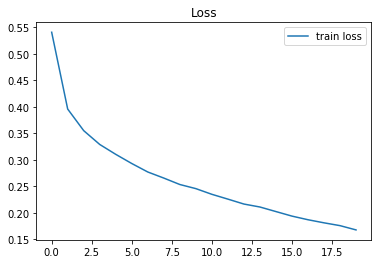

In [21]:
plt.plot(history.history["loss"], label="train loss")
plt.legend()
plt.title("Loss")
plt.show()

In [22]:
test_loss, test_acc = model1.evaluate(test_images, categorical_test_labels)
print('테스트 정확도:', test_acc)

10000/10000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 22us/step
테스트 정확도: 0.8781


-----------------------------------------

# Assignment 2 :
- 6주차 NN 기초 강의 과제였던 6_NeuralNetwork_HW.ipynb를 프레임워크로 구현
- PyTorch로 짠 예제 코드를 참고해주세요
- Batch Normalization, Dropout 등 NN 심화에서 다뤘던 내용을 활용

## 1) Data ( Pre-Processing)

In [23]:
import pandas as pd
from load_cifar_10 import *
import numpy as np

cifar_10_dir = 'cifar-10-batches-py'

train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = \
load_cifar_10_data(cifar_10_dir)

def Processing_data(train, test):
    #change dtype
    train = np.array(train, dtype=np.float64)
    test = np.array(test, dtype=np.float64)
    
    #Reshaping
    train = np.reshape(train, (train.shape[0], -1))
    test = np.reshape(test, (test.shape[0], -1))
    
    #Normalizing
    mean_image = np.mean(train, axis = 0)
    #print(train.dtype)
    train -= mean_image
    test -= mean_image
    
    return train, test

In [24]:
# Sampling
train_data, test_data = Processing_data(train_data, test_data)
train_data = train_data[:5000]
train_labels = train_labels[:5000]
test_data = test_data[:1000]
test_labels = test_labels[:1000]

In [25]:
from keras.utils import to_categorical
display(train_labels.shape)
categorical_labels = to_categorical(train_labels, num_classes=None)
categorical_test_labels = to_categorical(test_labels, num_classes=None)

display(categorical_labels.shape)

(5000,)

(5000, 10)

In [26]:
# Scaling
"""
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data= scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)
"""

'\nfrom sklearn.preprocessing import MinMaxScaler\nscaler = MinMaxScaler()\ntrain_data= scaler.fit_transform(train_data)\ntest_data = scaler.transform(test_data)\n'

## 2) Modeling 

In [27]:
# Hyper Parameters
input_size = 32 * 32 * 3
hidden_size = 50
output_size = 10
epoch_size = 100
batch_size = 100
learning_rate = 0.0001
N = train_data.shape[0]
M = test_data.shape[0] # 새롭게 추가

## 2-1) PyTorch

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [29]:
# Modeling
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # an affine operation : y = Wx + b
        self.fc1 = nn.Linear(input_size, hidden_size) # input, output
        # 1층은 3072 입력, 50으로 나옴 -> relu
        self.fc2 = nn.Linear(hidden_size, output_size)
        # 2층은 50측 입력 10층 나옴 -> sofrmax
    
    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))# 
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=3072, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [30]:
# Optimizer , Loss
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

In [31]:
history = {'val_acc': [],'val_loss': [], 'train_acc':[], 'train_loss':[]} #기록해서 그림 그리자!

#코드를 보며 epoch, batch에 대해서 이해해봅시다.
for i in range(epoch_size):
    correct = 0
    total = 0
    running_loss = 0
    for j in range(N//batch_size):
        batch_mask = np.random.choice(N, batch_size) #이번 배치에서 쓸 데이터들 인덱스 추출
        x_batch = torch.FloatTensor(train_data[batch_mask])
        t_batch = torch.LongTensor(train_labels[batch_mask])
        
        # Gradient buffer를 0으로 초기화
        optimizer.zero_grad()
        
        # Forward
        outputs = net(x_batch)
        # Backward
        loss = criterion(outputs, t_batch)
        loss.backward()
        # Update the weights
        optimizer.step()
        
        # Statistics
        _, predicted = torch.max(outputs.data, 1)
        total += t_batch.size(0)
        correct += (predicted == t_batch).sum().item()
        running_loss += loss.item()
        
    acc = 100*correct/total    
    history['train_loss'].append(running_loss / 50)
    history['train_acc'].append(acc)
    
    if i % 10 == 9: # print every 10 epochs 

        print('[%d] loss: %.3f acc: %.3f ' %
              (i + 1, running_loss / 10, acc))
        print('Accuracy of the network on the 50000 train images: %d %%' %  acc)
        running_loss = 0.0

    # Test
    correct = 0
    total = 0
    val_loss = 0

    with torch.no_grad():
        for k in range(M//batch_size):
            batch_mask = np.random.choice(M, batch_size) 
            #이번 배치에서 쓸 데이터들 인덱스 추출
            x_batch = torch.FloatTensor(test_data[batch_mask])
            t_batch = torch.LongTensor(test_labels[batch_mask])
            
             # Forward
            outputs = net(x_batch)

            # loss
            loss = criterion(outputs, t_batch)
                        
            # Statistics
            _, predicted = torch.max(outputs.data, 1)
            total += t_batch.size(0)
            correct += (predicted == t_batch).sum().item()
            val_loss += loss.item()
        
        #accuracy와 loss를 기록해둡시다.
        acc = 100*correct/total
        history["val_acc"].append(acc)
        history["val_loss"].append(val_loss / 10)
    
        if i % 10 == 9: # print every 10 epochs
            print('[%d] loss: %.3f acc: %.3f ' %
                  (i + 1, val_loss / 10, acc))
            print('Accuracy of the network on the 10000 test images: %d %%' % acc)
            val_loss = 0.0
            
print("")

[10] loss: 12.810 acc: 47.380 
Accuracy of the network on the 50000 train images: 47 %
[10] loss: 5.504 acc: 25.600 
Accuracy of the network on the 10000 test images: 25 %
[20] loss: 7.173 acc: 61.720 
Accuracy of the network on the 50000 train images: 61 %
[20] loss: 4.797 acc: 30.400 
Accuracy of the network on the 10000 test images: 30 %
[30] loss: 4.598 acc: 71.740 
Accuracy of the network on the 50000 train images: 71 %
[30] loss: 4.515 acc: 29.100 
Accuracy of the network on the 10000 test images: 29 %
[40] loss: 3.260 acc: 79.900 
Accuracy of the network on the 50000 train images: 79 %
[40] loss: 4.621 acc: 26.900 
Accuracy of the network on the 10000 test images: 26 %
[50] loss: 2.345 acc: 86.680 
Accuracy of the network on the 50000 train images: 86 %
[50] loss: 4.828 acc: 27.600 
Accuracy of the network on the 10000 test images: 27 %
[60] loss: 1.838 acc: 90.860 
Accuracy of the network on the 50000 train images: 90 %
[60] loss: 4.655 acc: 27.500 
Accuracy of the network on t

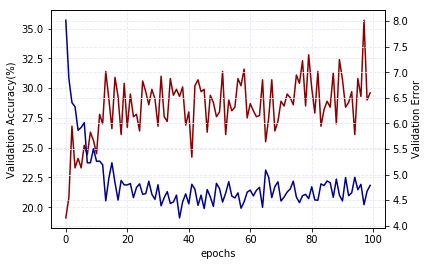

In [32]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

ax_acc.plot(range(epoch_size), history['val_acc'], label='정확도(%)', color='darkred')
#plt.text(3, 14.7, "<----------------정확도(%)", verticalalignment='top', horizontalalignment='right')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(epoch_size), history['val_loss'], label='오차', color='darkblue')
#plt.text(3, 2.2, "<----------------오차", verticalalignment='top', horizontalalignment='left')
plt.ylabel('Validation Error')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

## 2-2 Keras ( 과제 시작 ) 

### Data

In [33]:
# flatten을 여기서 해줌
keras_train = np.zeros(shape=(5000,3072))
keras_test = np.zeros(shape=(1000,3072))
for i in range(len(train_data)):
    keras_train[i] = train_data[i].flatten()
for i in range(len(test_data)):
    keras_test[i] = test_data[i].flatten()

#### 다른점 1 : MinMax로 스케일링 시도

In [34]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
keras_train_data= scaler.fit_transform(keras_train)
keras_test_data = scaler.transform(keras_test)

In [35]:
from keras.utils import to_categorical
categorical_labels = to_categorical(train_labels, num_classes=None)
categorical_test_labels = to_categorical(test_labels, num_classes=None)
display(categorical_labels.shape)

(5000, 10)

In [36]:
keras_train_data.shape

(5000, 3072)

### Modeling

In [37]:
categorical_test_labels.shape

(1000, 10)

In [38]:
from keras import models
from keras import layers
from keras.optimizers import SGD
from keras.layers import Flatten
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras import initializers

In [129]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
# 기존 코드와 똑같이 모델링
model2 = models.Sequential()
model2.add(layers.Dense(50, activation='relu', input_shape=(3072,)))#, kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)))
model2.add(layers.Dense(10, activation='softmax'))#,kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                153650    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
Total params: 154,160
Trainable params: 154,160
Non-trainable params: 0
_________________________________________________________________


In [40]:
model2.compile(optimizer=SGD(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])
history = model2.fit(keras_train_data, categorical_labels, validation_data=(keras_test_data,categorical_test_labels),
                     epochs=100, batch_size=100,
                     verbose=2)

Train on 5000 samples, validate on 1000 samples
Epoch 1/100
 - 1s - loss: 2.4650 - acc: 0.1006 - val_loss: 2.4241 - val_acc: 0.1090
Epoch 2/100
 - 0s - loss: 2.4002 - acc: 0.0958 - val_loss: 2.3771 - val_acc: 0.0990
Epoch 3/100
 - 1s - loss: 2.3666 - acc: 0.0932 - val_loss: 2.3509 - val_acc: 0.0990
Epoch 4/100
 - 0s - loss: 2.3466 - acc: 0.0898 - val_loss: 2.3344 - val_acc: 0.0970
Epoch 5/100
 - 0s - loss: 2.3329 - acc: 0.0946 - val_loss: 2.3223 - val_acc: 0.1100
Epoch 6/100
 - 0s - loss: 2.3223 - acc: 0.1006 - val_loss: 2.3130 - val_acc: 0.1200
Epoch 7/100
 - 0s - loss: 2.3138 - acc: 0.1080 - val_loss: 2.3050 - val_acc: 0.1280
Epoch 8/100
 - 0s - loss: 2.3063 - acc: 0.1124 - val_loss: 2.2982 - val_acc: 0.1300
Epoch 9/100
 - 0s - loss: 2.2997 - acc: 0.1162 - val_loss: 2.2920 - val_acc: 0.1330
Epoch 10/100
 - 0s - loss: 2.2936 - acc: 0.1194 - val_loss: 2.2864 - val_acc: 0.1370
Epoch 11/100
 - 0s - loss: 2.2880 - acc: 0.1254 - val_loss: 2.2813 - val_acc: 0.1430
Epoch 12/100
 - 0s - loss:

Epoch 97/100
 - 0s - loss: 2.0916 - acc: 0.2506 - val_loss: 2.1140 - val_acc: 0.2330
Epoch 98/100
 - 0s - loss: 2.0903 - acc: 0.2528 - val_loss: 2.1129 - val_acc: 0.2350
Epoch 99/100
 - 0s - loss: 2.0890 - acc: 0.2544 - val_loss: 2.1118 - val_acc: 0.2360
Epoch 100/100
 - 0s - loss: 2.0877 - acc: 0.2566 - val_loss: 2.1107 - val_acc: 0.2390


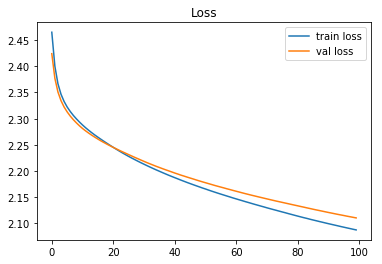

In [41]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.title("Loss")
plt.show()

### Model Development
 1) Hidden Layer 노드 개수가 비 정상적 <span style="color:red">( 과제의 주제와 조금 떨어져 있으므로 마지막에 진행 ) </span>   
 2) 가중치 초기화 과정 X  
 3) Batch Normalization 과정 X  
 4) 층이 너무 얕음   <span style="color:red">( 과제의 주제와 조금 떨어져 있으므로 마지막에 진행 ) </span>   
 5) epoch 더 올려도 충분히 loss가 감소할 듯  
 6) dropout  
 7) optimizer 변경

In [42]:
# 가중치 초기화 + Batch Normalization 
from keras.layers import BatchNormalization
from keras.layers import Activation, Dense
model3 = models.Sequential()

model3.add(Dense(50, input_shape=(3072,), kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)))
model3.add(BatchNormalization()) 
model3.add(Activation('relu')) 
model3.add(Dense(10, kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)))
model3.add(BatchNormalization()) 
model3.add(Activation('softmax'))


model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 50)                153650    
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
batch_normalization_2 (Batch (None, 10)                40        
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 154,400
Trainable params: 154,280
Non-trainable params: 120
_________________________________________________________________


In [43]:
# optimizer Adam 사용
model3.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])
history = model3.fit(keras_train_data, categorical_labels, validation_data=(keras_test_data,categorical_test_labels),
                     epochs=100, batch_size=100,
                     verbose=2)

Train on 5000 samples, validate on 1000 samples
Epoch 1/100
 - 1s - loss: 2.4934 - acc: 0.1508 - val_loss: 2.8276 - val_acc: 0.1620
Epoch 2/100
 - 0s - loss: 2.1868 - acc: 0.2222 - val_loss: 2.2421 - val_acc: 0.2240
Epoch 3/100
 - 0s - loss: 2.0604 - acc: 0.2732 - val_loss: 2.1147 - val_acc: 0.2380
Epoch 4/100
 - 0s - loss: 1.9936 - acc: 0.2942 - val_loss: 2.0693 - val_acc: 0.2660
Epoch 5/100
 - 0s - loss: 1.9351 - acc: 0.3180 - val_loss: 2.0036 - val_acc: 0.2780
Epoch 6/100
 - 1s - loss: 1.8965 - acc: 0.3282 - val_loss: 1.9618 - val_acc: 0.2830
Epoch 7/100
 - 1s - loss: 1.8612 - acc: 0.3456 - val_loss: 1.9381 - val_acc: 0.3030
Epoch 8/100
 - 1s - loss: 1.8327 - acc: 0.3542 - val_loss: 1.9208 - val_acc: 0.3110
Epoch 9/100
 - 1s - loss: 1.8079 - acc: 0.3676 - val_loss: 1.8996 - val_acc: 0.3230
Epoch 10/100
 - 1s - loss: 1.7817 - acc: 0.3742 - val_loss: 1.8847 - val_acc: 0.3180
Epoch 11/100
 - 1s - loss: 1.7618 - acc: 0.3838 - val_loss: 1.8780 - val_acc: 0.3120
Epoch 12/100
 - 0s - loss:

Epoch 97/100
 - 0s - loss: 0.9369 - acc: 0.7690 - val_loss: 1.9024 - val_acc: 0.3610
Epoch 98/100
 - 0s - loss: 0.9285 - acc: 0.7808 - val_loss: 1.8987 - val_acc: 0.3640
Epoch 99/100
 - 1s - loss: 0.9214 - acc: 0.7802 - val_loss: 1.9330 - val_acc: 0.3540
Epoch 100/100
 - 1s - loss: 0.9114 - acc: 0.7888 - val_loss: 1.8996 - val_acc: 0.3630


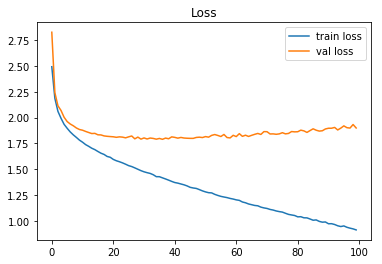

In [44]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.title("Loss")
plt.show()

####  Overfitting -> 규제추가

In [121]:
# 가중치 초기화 + Batch Normalization + 규제 + Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation, Dense
model3 = models.Sequential()

model3.add(Dense(50, input_shape=(3072,), kernel_initializer = 'he_normal',
                kernel_constraint=max_norm(2.)))
model3.add(BatchNormalization()) 
model3.add(Activation('relu')) 
model3.add(Dropout(0.4))

model3.add(Dense(10, kernel_initializer = 'he_normal',
                kernel_constraint=max_norm(2.)))
model3.add(BatchNormalization()) 
model3.add(Activation('softmax'))


model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 50)                153650    
_________________________________________________________________
batch_normalization_90 (Batc (None, 50)                200       
_________________________________________________________________
activation_53 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_97 (Dense)             (None, 10)                510       
_________________________________________________________________
batch_normalization_91 (Batc (None, 10)                40        
_________________________________________________________________
activation_54 (Activation)   (None, 10)                0         
Total params: 154,400
Trainable params: 154,280
Non-trainable params: 120
_________________________________________________________________


In [122]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=10)
model3.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])
history = model3.fit(keras_train_data, categorical_labels, validation_data=(keras_test_data,categorical_test_labels),
                     epochs=100, batch_size=100,callbacks=[early_stop],
                     verbose=2)

Train on 5000 samples, validate on 1000 samples
Epoch 1/100
 - 10s - loss: 2.2769 - acc: 0.2004 - val_loss: 2.3903 - val_acc: 0.2010
Epoch 2/100
 - 1s - loss: 1.9458 - acc: 0.3172 - val_loss: 2.1329 - val_acc: 0.2650
Epoch 3/100
 - 1s - loss: 1.8390 - acc: 0.3532 - val_loss: 1.9833 - val_acc: 0.3210
Epoch 4/100
 - 1s - loss: 1.7677 - acc: 0.3816 - val_loss: 1.9908 - val_acc: 0.3000
Epoch 5/100
 - 1s - loss: 1.7115 - acc: 0.4090 - val_loss: 1.9226 - val_acc: 0.3230
Epoch 6/100
 - 1s - loss: 1.6645 - acc: 0.4332 - val_loss: 1.9227 - val_acc: 0.3150
Epoch 7/100
 - 1s - loss: 1.6270 - acc: 0.4486 - val_loss: 1.9041 - val_acc: 0.3160
Epoch 8/100
 - 1s - loss: 1.5934 - acc: 0.4576 - val_loss: 1.8976 - val_acc: 0.3220
Epoch 9/100
 - 1s - loss: 1.5624 - acc: 0.4804 - val_loss: 1.9281 - val_acc: 0.3150
Epoch 10/100
 - 1s - loss: 1.5312 - acc: 0.4926 - val_loss: 1.8777 - val_acc: 0.3540
Epoch 11/100
 - 1s - loss: 1.5059 - acc: 0.5126 - val_loss: 1.8788 - val_acc: 0.3270
Epoch 12/100
 - 1s - loss

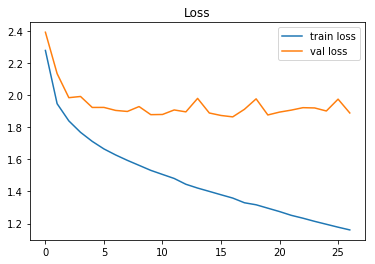

In [123]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.title("Loss")
plt.show()

 큰 변화 없음, 구조의 한계인듯 -> 층을 다르고 깊게 쌓아보자

In [124]:
# 가중치 초기화 + Batch Normalization  + 규제
from keras.layers import BatchNormalization
from keras.layers import Activation, Dense
model4 = models.Sequential()

model4.add(Dense(128, input_shape=(3072,), kernel_initializer="he_normal",
                 kernel_constraint=max_norm(2.)))
                 #kernel_regularizer=regularizers.l2(0.01)))
model4.add(BatchNormalization()) 
model4.add(Activation('relu')) 
model4.add(Dropout(0.2))

model4.add(Dense(128, kernel_initializer="he_normal",
                 kernel_constraint=max_norm(2.)))
#                 kernel_regularizer=regularizers.l2(0.01)))
model4.add(BatchNormalization()) 
model4.add(Dropout(0.2))

model4.add(Dense(128, kernel_initializer="he_normal",
                 kernel_constraint=max_norm(2.)))
#                 kernel_regularizer=regularizers.l2(0.01)))
model4.add(BatchNormalization()) 
model4.add(Dropout(0.2))

model4.add(Dense(128, kernel_initializer="he_normal",
                 kernel_constraint=max_norm(2.)))
#                 kernel_regularizer=regularizers.l2(0.01)))
model4.add(BatchNormalization()) 
model4.add(Dropout(0.2))

model4.add(Dense(128, kernel_initializer="he_normal",
                 kernel_constraint=max_norm(2.)))
       #          kernel_regularizer=regularizers.l2(0.01)))
model4.add(BatchNormalization()) 
model4.add(Dropout(0.2))

model4.add(Dense(10, kernel_initializer="he_normal",
                 kernel_constraint=max_norm(2.)))
        #         kernel_regularizer=regularizers.l2(0.01)))
model4.add(BatchNormalization()) 
model4.add(Activation('softmax'))


model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 128)               393344    
_________________________________________________________________
batch_normalization_92 (Batc (None, 128)               512       
_________________________________________________________________
activation_55 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_93 (Batc (None, 128)               512       
_________________________________________________________________
dropout_64 (Dropout)         (None, 128)               0         
__________

In [125]:
# optimizer Adam 사용
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=20)
model4.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])
history = model4.fit(keras_train_data, categorical_labels, validation_data=(keras_test_data,categorical_test_labels),
                     epochs=1000, batch_size=128,callbacks=[early_stop],
                     verbose=2)

Train on 5000 samples, validate on 1000 samples
Epoch 1/1000
 - 11s - loss: 2.3720 - acc: 0.1816 - val_loss: 2.0981 - val_acc: 0.2420
Epoch 2/1000
 - 2s - loss: 2.1293 - acc: 0.2482 - val_loss: 1.9563 - val_acc: 0.3020
Epoch 3/1000
 - 3s - loss: 2.0110 - acc: 0.2832 - val_loss: 1.9235 - val_acc: 0.3110
Epoch 4/1000
 - 2s - loss: 1.9393 - acc: 0.3100 - val_loss: 1.8833 - val_acc: 0.3360
Epoch 5/1000
 - 2s - loss: 1.9193 - acc: 0.3196 - val_loss: 1.8663 - val_acc: 0.3340
Epoch 6/1000
 - 3s - loss: 1.8597 - acc: 0.3350 - val_loss: 1.8381 - val_acc: 0.3410
Epoch 7/1000
 - 2s - loss: 1.8400 - acc: 0.3470 - val_loss: 1.8440 - val_acc: 0.3350
Epoch 8/1000
 - 3s - loss: 1.8188 - acc: 0.3456 - val_loss: 1.8187 - val_acc: 0.3410
Epoch 9/1000
 - 2s - loss: 1.7991 - acc: 0.3688 - val_loss: 1.8079 - val_acc: 0.3730
Epoch 10/1000
 - 2s - loss: 1.7814 - acc: 0.3676 - val_loss: 1.8021 - val_acc: 0.3540
Epoch 11/1000
 - 3s - loss: 1.7578 - acc: 0.3854 - val_loss: 1.7850 - val_acc: 0.3590
Epoch 12/1000


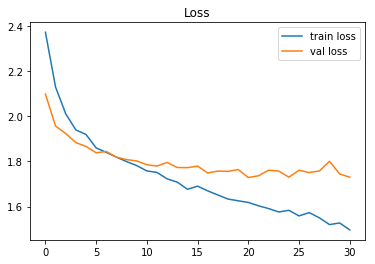

In [126]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.title("Loss")
plt.show()

In [128]:
# optimizer Nadam 사용
# 가중치 초기화 + Batch Normalization  + 규제
from keras.layers import BatchNormalization
from keras.layers import Activation, Dense
model4 = models.Sequential()

model4.add(Dense(128, input_shape=(3072,), kernel_initializer="he_normal",
                 kernel_constraint=max_norm(2.)))
                 #kernel_regularizer=regularizers.l2(0.01)))
model4.add(BatchNormalization()) 
model4.add(Activation('relu')) 
model4.add(Dropout(0.2))

model4.add(Dense(128, kernel_initializer="he_normal",
                 kernel_constraint=max_norm(2.)))
#                 kernel_regularizer=regularizers.l2(0.01)))
model4.add(BatchNormalization()) 
model4.add(Dropout(0.2))

model4.add(Dense(128, kernel_initializer="he_normal",
                 kernel_constraint=max_norm(2.)))
#                 kernel_regularizer=regularizers.l2(0.01)))
model4.add(BatchNormalization()) 
model4.add(Dropout(0.2))

model4.add(Dense(128, kernel_initializer="he_normal",
                 kernel_constraint=max_norm(2.)))
#                 kernel_regularizer=regularizers.l2(0.01)))
model4.add(BatchNormalization()) 
model4.add(Dropout(0.2))

model4.add(Dense(128, kernel_initializer="he_normal",
                 kernel_constraint=max_norm(2.)))
       #          kernel_regularizer=regularizers.l2(0.01)))
model4.add(BatchNormalization()) 
model4.add(Dropout(0.2))

model4.add(Dense(10, kernel_initializer="he_normal",
                 kernel_constraint=max_norm(2.)))
        #         kernel_regularizer=regularizers.l2(0.01)))
model4.add(BatchNormalization()) 
model4.add(Activation('softmax'))


model4.summary()
from keras.optimizers import Nadam
early_stop = EarlyStopping(patience=20)
model4.compile(optimizer=Nadam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])
history = model4.fit(keras_train_data, categorical_labels, validation_data=(keras_test_data,categorical_test_labels),
                     epochs=1000, batch_size=128,callbacks=[early_stop],
                     verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_104 (Dense)            (None, 128)               393344    
_________________________________________________________________
batch_normalization_98 (Batc (None, 128)               512       
_________________________________________________________________
activation_57 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_105 (Dense)            (None, 128)               16512     
_________________________________________________________________
batch_normalization_99 (Batc (None, 128)               512       
_________________________________________________________________
dropout_69 (Dropout)         (None, 128)               0         
__________

validation에서 불안정한 학습, Adam채택